In [7]:
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import timm
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from PIL import Image


print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)



System Version: 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
PyTorch version 2.4.1+cpu
Torchvision version 0.19.1+cpu
Numpy version 1.26.3
Pandas version 2.2.3


In [8]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

In [9]:
dataset = ChestXrayDataset(r'dataset\train')
print(len(dataset))

5216


0


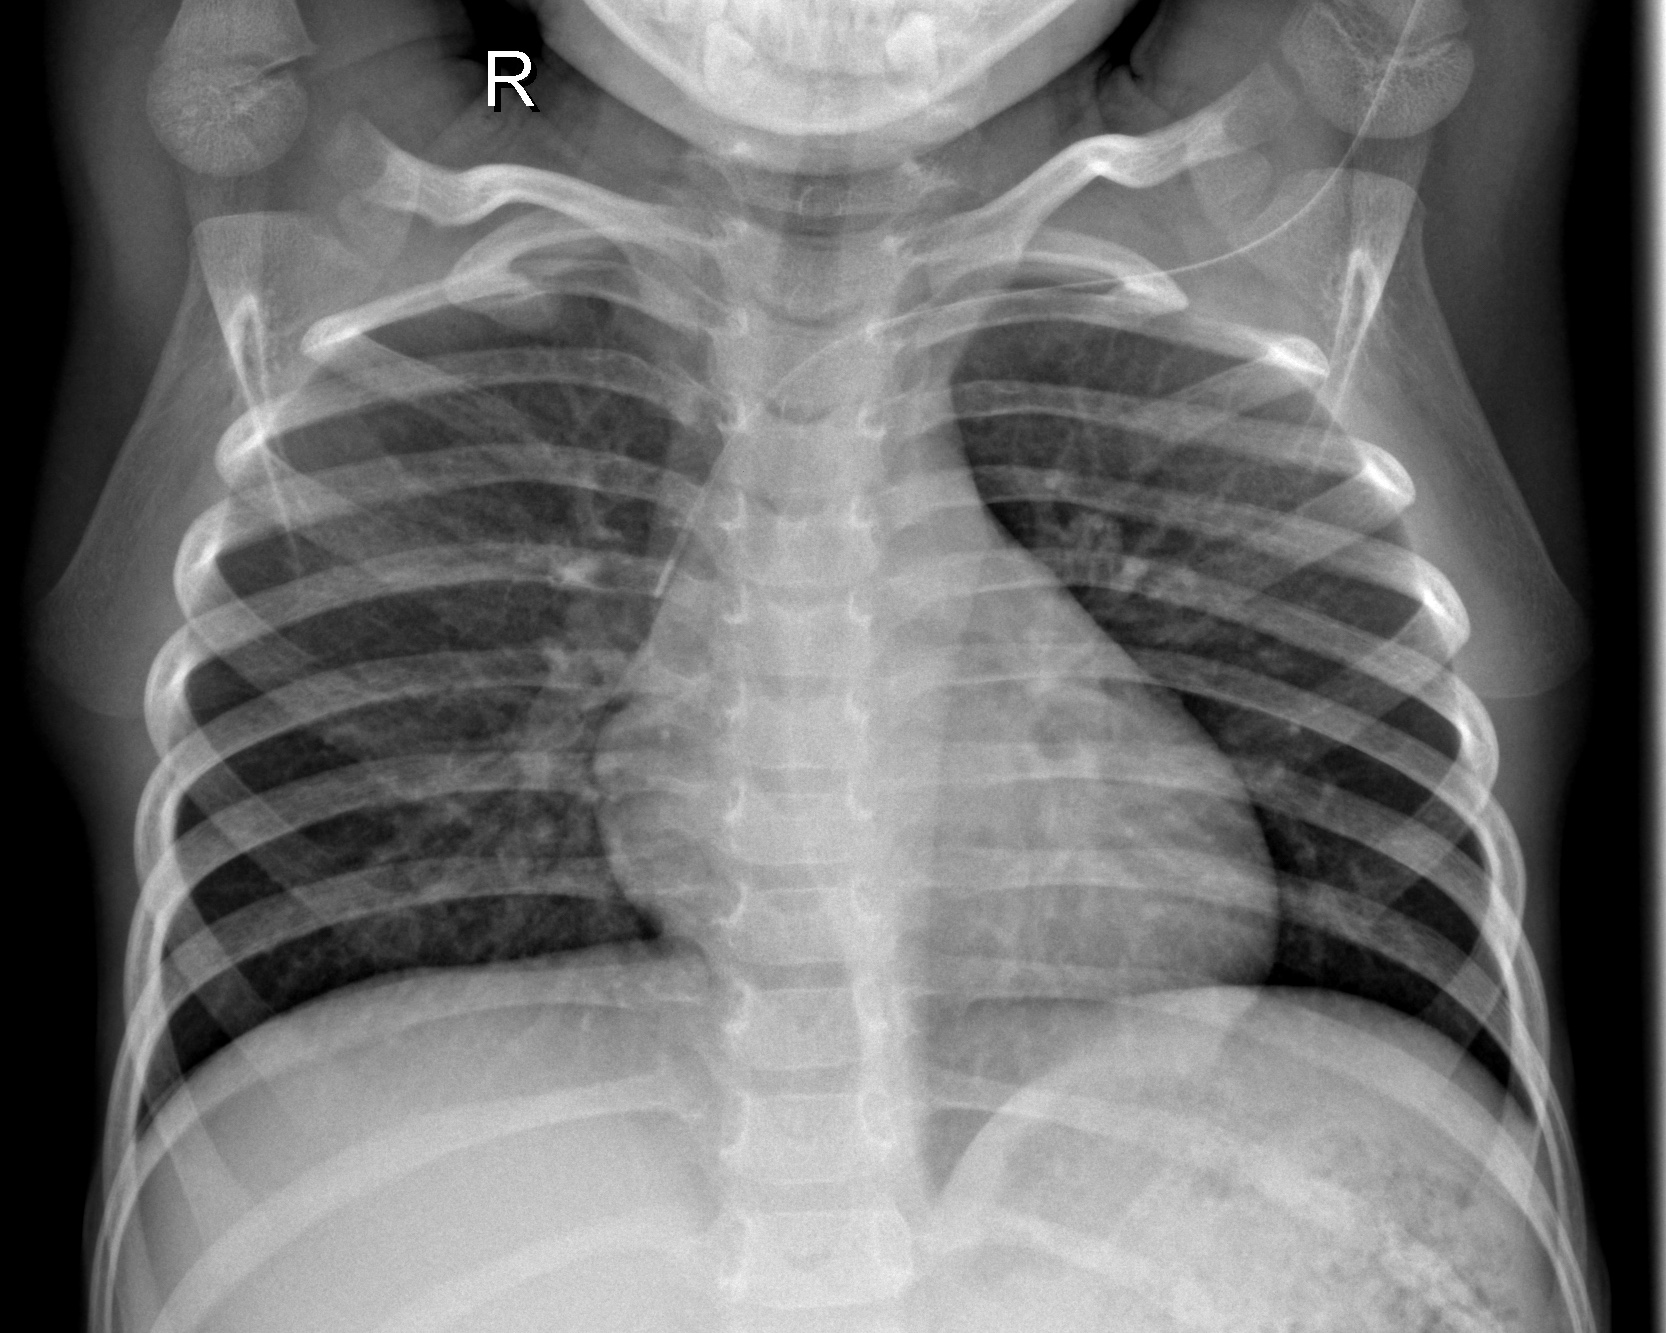

In [10]:
image, label = dataset[200]
print(label)
image

In [11]:
transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])

train_data = ChestXrayDataset(r'dataset\train', transform)
test_data = ChestXrayDataset(r'dataset\test', transform)
val_data = ChestXrayDataset(r'dataset\val', transform)

In [12]:
image, label = train_data[100]
print(image.shape)

torch.Size([3, 128, 128])


In [13]:
dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

In [14]:
i = 1
for images, labels in dataloader:
    break
image.shape, labels.shape

(torch.Size([3, 128, 128]), torch.Size([32]))

In [15]:
labels

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1])

In [16]:
class TuberculosisClassfier(nn.Module):

    def __init__(self):
        super(TuberculosisClassfier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Assuming input images are 128x128
        self.fc2 = nn.Linear(128, 2)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 32 * 32 * 32)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer
        
        return x
    
model = TuberculosisClassfier()  
print(model)



TuberculosisClassfier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [18]:
num_epochs = 3
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], []

train_folder = r'dataset\train'
test_folder = r'dataset\test'
val_folder = r'dataset\val'

train_dataset = ChestXrayDataset(train_folder, transform)
test_dataset = ChestXrayDataset(test_folder, transform)
val_dataset = ChestXrayDataset(val_folder, transform)

train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    running_accuracy = 0
    for images, labels in tqdm(train_data_loader, desc='Training loop'):
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        running_accuracy += (output.argmax(1) == labels).float().sum() 
    train_loss = running_loss / len(train_data_loader.dataset)
    train_accuracy = running_accuracy / len(train_data_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        running_loss = 0 
        running_accuracy = 0
        for images, labels in tqdm(val_data_loader, desc='Validation loop'):
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item() * labels.size(0)
            running_accuracy += (output.argmax(1) == labels).float().sum()
    val_loss = running_loss / len(val_data_loader.dataset)
    val_accuracy = running_accuracy / len(val_data_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}, Train accuracy: {train_accuracy * 100}%, Validation accuracy: {val_accuracy * 100}%")
 





Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/3 - Train loss: 0.4491735885114026, Validation loss: 0.5853264331817627, Train accuracy: 79.81211853027344%, Validation accuracy: 81.25%


Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/3 - Train loss: 0.2181000514812996, Validation loss: 0.6515182256698608, Train accuracy: 91.14263916015625%, Validation accuracy: 68.75%


Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/3 - Train loss: 0.16252574278898765, Validation loss: 0.3529042601585388, Train accuracy: 92.96395874023438%, Validation accuracy: 87.5%


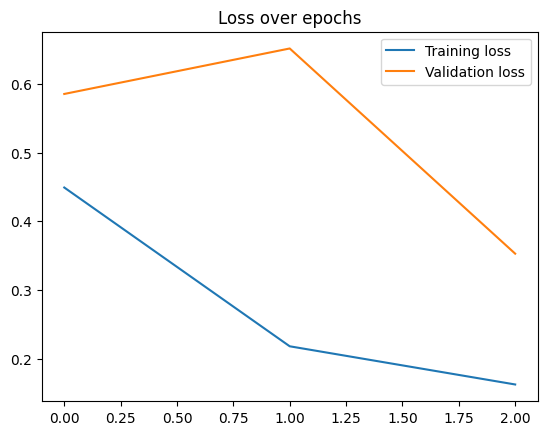

In [19]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

NORMAL2-IM-0322-0001.jpeg


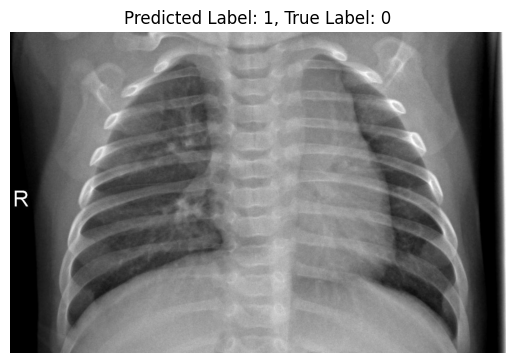

NORMAL2-IM-0330-0001.jpeg


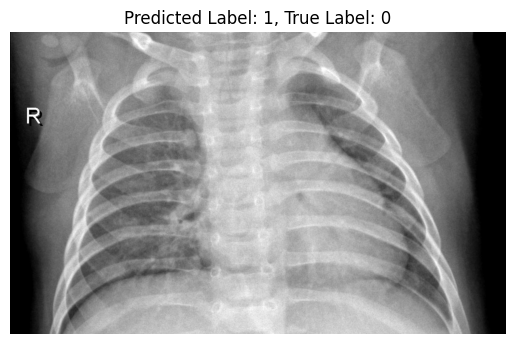

person45_virus_95.jpeg


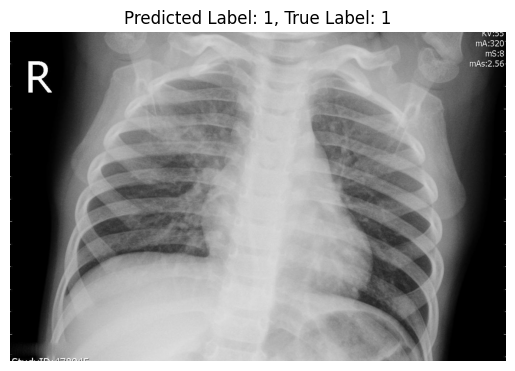

person139_bacteria_662.jpeg


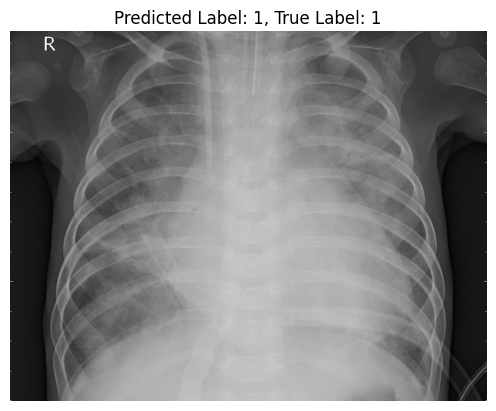

person140_bacteria_668.jpeg


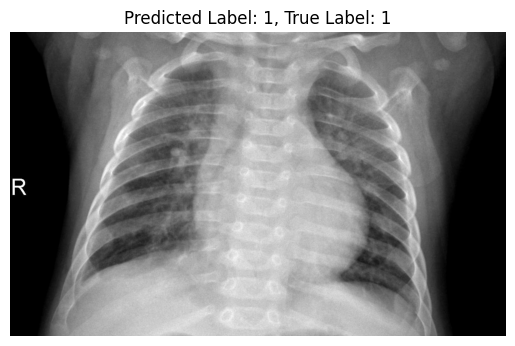

NORMAL2-IM-0246-0001-0002.jpeg


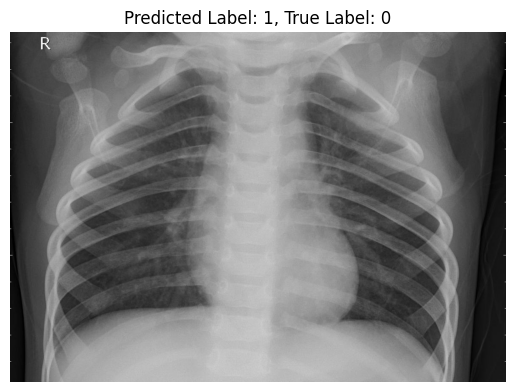

person101_bacteria_484.jpeg


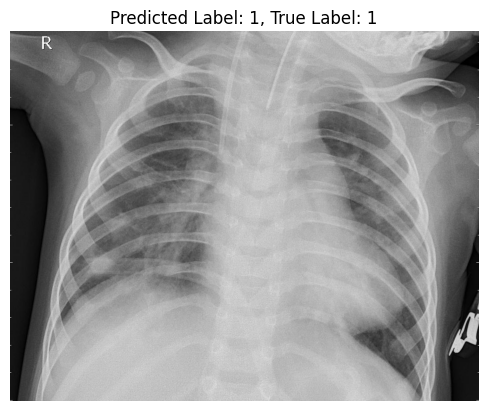

NORMAL2-IM-0307-0001.jpeg


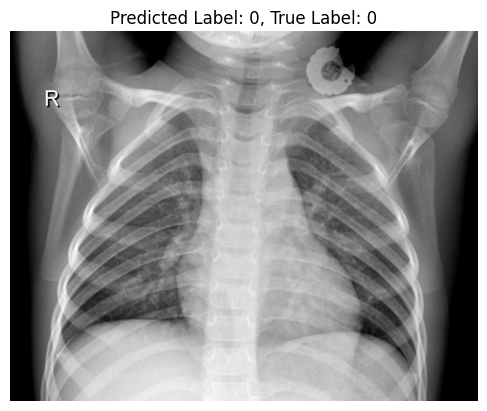

NORMAL2-IM-0117-0001.jpeg


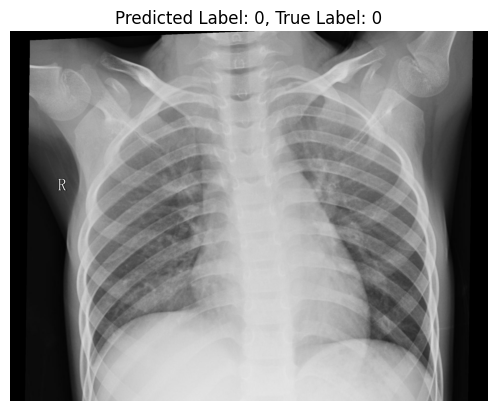

NORMAL2-IM-0336-0001.jpeg


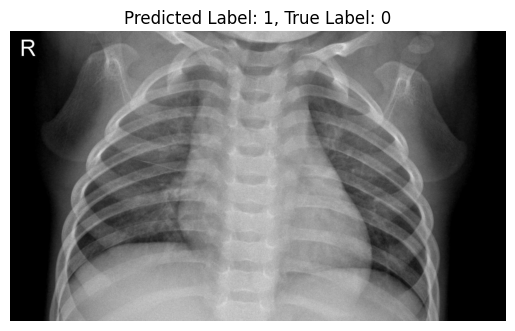

person114_bacteria_544.jpeg


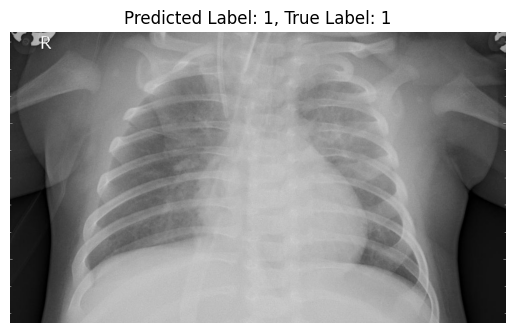

person136_bacteria_650.jpeg


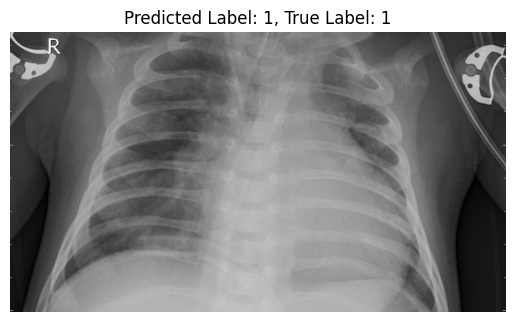

In [20]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

def predict_label(model, image_path, transform):
    model.eval()
    image, preprocessed_image = preprocess_image(image_path, transform)
    with torch.no_grad():
        output = model(preprocessed_image)
    return image, output.argmax(dim=1).item()

def show_image(image, output, true_label):
    plt.imshow(image)
    plt.title(f"Predicted Label: {output}, True Label: {true_label}")
    plt.axis('off')
    plt.show()

def predict_random_images(total_images_to_predict):
    normal_folder = r'dataset\test\NORMAL'
    pneumonia_folder = r'dataset\test\PNEUMONIA'
    
    normal_images = os.listdir(normal_folder)
    pneumonia_images = os.listdir(pneumonia_folder)

    for _ in range(total_images_to_predict):
        rand = random.randint(0, 1)
        
        if rand == 0:
            chosen_folder = normal_folder
            chosen_image = random.choice(normal_images)
        else:
            chosen_folder = pneumonia_folder
            chosen_image = random.choice(pneumonia_images)
        
        image_path = os.path.join(chosen_folder, chosen_image)
        image, output = predict_label(model, image_path, transform)
        print(chosen_image)
        show_image(image, output, rand)

predict_random_images(12)
